In [1]:
%cd ../

/home/tadenoud/Git/simple-faster-rcnn-pytorch


In [2]:
RANDOM_SEED = 42
SUBSET_SAMPLE_DATA_PERCENTAGE = 0.1
MIN_IOU_REQUIRED = 0.7  # The minimum IOU required to be a good detection (ie higher is more strict)
NUM_PROPOSALS = 300
CHECKPOINT_DIR = './idd_fp_detection'

%load_ext autoreload
%autoreload 2

import os
import torch as t
from model import FasterRCNNVGG16
from trainer import FasterRCNNTrainer
import numpy as np
import pickle
import h5py
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

from data.util import  read_image
from utils.vis_tool import vis_bbox
from utils import array_tool as at
from utils.config import opt
from utils.idd_utils import get_annotations
from model.utils.bbox_tools import bbox_iou

from data.dataset import Dataset, TestDataset, KittiDataset
from torch.utils.data import DataLoader
from utils.vis_tool import vis_bbox, vis_image
from utils.idd_utils import IndiaDrivingDataset
from ood_metrics import auroc, plot_roc, calc_metrics
from sklearn import svm
import pickle
import itertools
import torch
from model.faster_rcnn import nograd
from data.dataset import preprocess
from utils.mahalanobis import Mahal_Dist


import warnings
warnings.filterwarnings(action='once')

np.random.seed(RANDOM_SEED)

In [3]:
%matplotlib inline

In [4]:
# fg_detections = 13115
# bg_detections = 292551

# data_portion = fg_detections / bg_detections

data_portion = 1.0
print(data_portion)

1.0


In [5]:
opt.voc_data_dir = "./datasets/kitti_2d/VOC2012/"
idd_data_dir = "./datasets/idd_detection/"

# Subsample full dataset
kitti_train_dataset = KittiDataset(opt, split='train')
kitti_val_dataset = KittiDataset(opt, split='val')
idd_val_dataset = IndiaDrivingDataset(idd_data_dir, split='val', keep_labels=[0])

kitti_train_samples = round(len(kitti_train_dataset) * data_portion)
kitti_val_samples = round(len(kitti_val_dataset) * data_portion)
idd_val_samples = round(len(idd_val_dataset) * data_portion)

KITTI_TRAIN_TO_USE = np.random.choice(kitti_train_samples, kitti_train_samples, replace=False)
KITTI_VAL_TO_USE = np.random.choice(kitti_val_samples, kitti_val_samples, replace=False)
IDD_VAL_TO_USE = np.random.choice(idd_val_samples, idd_val_samples, replace=False)

kitti_train_dataset = torch.utils.data.Subset(kitti_train_dataset, KITTI_TRAIN_TO_USE)
kitti_val_dataset = torch.utils.data.Subset(kitti_val_dataset, KITTI_VAL_TO_USE)
idd_val_dataset = torch.utils.data.Subset(idd_val_dataset, IDD_VAL_TO_USE)


# Subset Datasets
subset_kitti_train_samples = round(kitti_train_samples * SUBSET_SAMPLE_DATA_PERCENTAGE)
subset_kitti_val_samples = round(kitti_val_samples * SUBSET_SAMPLE_DATA_PERCENTAGE)
subset_idd_val_samples = round(idd_val_samples * SUBSET_SAMPLE_DATA_PERCENTAGE)

SUBSET_KITTI_TRAIN_TO_USE = np.random.choice(subset_kitti_train_samples, subset_kitti_train_samples, replace=False)
SUBSET_KITTI_VAL_TO_USE = np.random.choice(subset_kitti_val_samples, subset_kitti_val_samples, replace=False)
SUBSET_IDD_VAL_TO_USE = np.random.choice(subset_idd_val_samples, subset_idd_val_samples, replace=False)

subset_kitti_train_dataset = torch.utils.data.Subset(kitti_train_dataset, SUBSET_KITTI_TRAIN_TO_USE)
subset_kitti_val_dataset = torch.utils.data.Subset(kitti_val_dataset, SUBSET_KITTI_VAL_TO_USE)
subset_idd_val_dataset = torch.utils.data.Subset(idd_val_dataset, SUBSET_IDD_VAL_TO_USE)

# Extract classifier features

In [9]:
string_dt = h5py.string_dtype(encoding='utf-8')
feature_layer_sizes = (512, 4096, 4096)

In [10]:
def extract_kitti_features(dataset, model, save_file, perturbation=0, temperature=1):
    """
    Given a Kitti dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    _extract_features("kitti", dataset, model, save_file, perturbation, temperature)
                
                
def extract_idd_features(dataset, model, save_file, perturbation=0, temperature=1):
    """
    Given a IDD dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    _extract_features("idd", dataset, model, save_file, perturbation, temperature)
                

def show_max_ious_dist(data_file):
    """
    Given a data file generated by one of the feature_extractor functions, show the distribution 
    of IOUs with the gt data.
    """
    total_false_negatives = 0
    total_false_positives = 0
    total_true_positives = 0
    total_true_negatives = 0
    
    all_max_ious = np.array([])
    all_labels = np.array([])

    with h5py.File(data_file, "r") as f:
        dset_length = len(f)
        for i in range(dset_length):
            d = f[str(i)]
            pred_labels = d["pred_labels"][()]
            pred_label_corrects = d["pred_label_correct"][()]
            max_ious = d["pred_max_ious"][()]

            false_positives = ([lab >= 0 and \
                                (miou < MIN_IOU_REQUIRED or not corr) \
                                for miou, lab, corr in zip(max_ious, pred_labels, pred_label_corrects)])
            
            false_negatives = ([lab < 0 and \
                                (miou >= MIN_IOU_REQUIRED or not corr) \
                                for miou, lab, corr in zip(max_ious, pred_labels, pred_label_corrects)])

            true_positives = ([lab >= 0 and \
                               (miou >= MIN_IOU_REQUIRED and corr) \
                                for miou, lab, corr in zip(max_ious, pred_labels, pred_label_corrects)])
            
            true_negatives = ([lab < 0 and \
                               (miou < MIN_IOU_REQUIRED and corr) \
                               for miou, lab, corr in zip(max_ious, pred_labels, pred_label_corrects)])

            total_false_positives += sum(false_positives)
            total_false_negatives += sum(false_negatives)
            total_true_positives += sum(true_positives)
            total_true_negatives += sum(true_negatives)

            all_max_ious = np.concatenate((all_max_ious, max_ious), axis=0)
            all_labels = np.concatenate((all_labels, pred_labels), axis=0)
            
    plt.hist(all_max_ious[all_labels>=0], bins=50)
    plt.title("Predicted FG objects IOUs")
    plt.ylabel("Count")
    plt.xlabel("Max IOUS")
    plt.show()
    
    plt.hist(all_max_ious[all_labels<0], bins=50)
    plt.title("Predicted BG objects IOUs")
    plt.ylabel("Count")
    plt.xlabel("Max IOUS")
    plt.show()

    total_fg_detections = len(all_max_ious[all_labels>=0])
    total_bg_detections = len(all_max_ious[all_labels<0])
    
    print("FPs: %d" % total_false_positives)
    print("FNs: %d" % total_false_negatives)
    print("TPs: %d" % total_true_positives)
    print("TNs: %d" % total_true_negatives)
    print()
    print("Total FG detections: %d" % (total_fg_detections))
    print("Total BG detections: %d" % (total_bg_detections))
    print()
    print("FP/TP+FP: %f%%" % (total_false_positives/total_fg_detections * 100))
    print("FN/TN+FN: %f%%" % (total_false_negatives/total_bg_detections * 100))
    

def read_features(save_file, feature_idx, start=0, end=None, leave=True):
    """
    Read the features from the extracted HD5F feature file and return them as a numpy array
    along with a label array y describing if the features correspond to a high IOU gt box with
    the same classification as the prediction.
    
    Label array is 1 for a false positive and 0 for a true positive
    """
    with h5py.File(save_file, "r") as f:       
        X = None
        y = np.empty((0,))
        
        if end is None or end > len(f):
            end = len(f)
        
        for i in trange(start, end, leave=leave):
            d = f[str(i)]
            features = d["pred_features_%d" % feature_idx][()]
            
            # Select only the negative preds
            label_is_fg = d["pred_labels"][()] >= 0
            mask = label_is_fg
            
            if X is None:
                # Initialize X array to correct size
                X = np.copy(features[mask])
            else:
                X = np.concatenate((X, features[mask]), axis=0)
            
            iou_is_high_enough = d["pred_max_ious"][()][mask] >= MIN_IOU_REQUIRED
            classification_is_correct = d["pred_label_correct"][()][mask] == 1

            # Determine if each bbox is a high accuracy, correct class case
            label = iou_is_high_enough & classification_is_correct
            y = np.concatenate((y, label.astype(np.int)), axis=0)
            
    return X, 1 - y


def read_scores(save_file, start=0, end=None, leave=True):
    """
    Read the max_softmax scores from the extracted HD5F feature file and return them as a numpy array
    along with a label array y describing if the features correspond to a high IOU gt box with
    the same classification as the prediction.
    
    Label array is 1 for a false positive and 0 for a true positive
    """
    with h5py.File(save_file, "r") as f:       
        X = None
        y = np.empty((0,))
        
        if end is None or end > len(f):
            end = len(f)
            
        for i in trange(start, end, leave=leave):
            d = f[str(i)]
            features = d["pred_scores"][()]
            
            # Select only the negative preds
            label_is_fg = d["pred_labels"][()] >= 0
            mask = label_is_fg
            
            if X is None:
                # Initialize X array to correct size
                X = np.copy(features[mask])
            else:
                X = np.concatenate((X, features[mask]), axis=0)
            
            iou_is_high_enough = d["pred_max_ious"][()][mask] >= MIN_IOU_REQUIRED
            classification_is_correct = d["pred_label_correct"][()][mask] == 1

            # Determine if each bbox is a high accuracy, correct class case
            label = iou_is_high_enough & classification_is_correct
            y = np.concatenate((y, label.astype(np.int)), axis=0)
            
    return X, 1 - y


def chunked_calc(read_func, read_func_args, save_file, novelty_func, chunk_size):
    scores = []
    labels = []
    
    l = 0
    with h5py.File(save_file, 'r') as f:
        l = len(f)
     
    for i in range(0, l, chunk_size):
        X, y = read_func(*read_func_args, start=i, end=i+chunk_size, leave=False)
        scores.append(novelty_func(X))
        labels.append(y)
        
    return np.concatenate(scores, axis=0), np.concatenate(labels, axis=0)

In [11]:
def risk_coverage(scores, gt_labels):
    """High scores would ideally correspond to a gt_label of 1."""
    scores_ = -np.array(scores)
    gt_labels_ = np.array(gt_labels)
     
    coverage = []
    risk = []
    for theta in scores_:
        mask = scores_ >= theta  # TODO: >= or > ? Doing >= so that risk is defined when coverage == 0
        
        coverage.append(len(scores_[mask]) / len(scores_))
        risk.append(sum(gt_labels_[mask]) / len(gt_labels_))
    
    coverage, risk = np.array(sorted(zip(coverage, risk), key=lambda x: x[0])).T
    return coverage, risk
  
    
def plot_risk_coverage(*args):
    c, r = risk_coverage(*args)
    
    plt.figure()
    plt.plot(c, r)
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.05])
    plt.ylabel("Risk")
    plt.xlabel("Coverage")
    plt.show()

# Extract classifier features

#### Kitti Train

In [12]:
%reset -f array

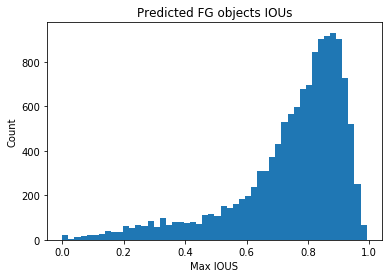

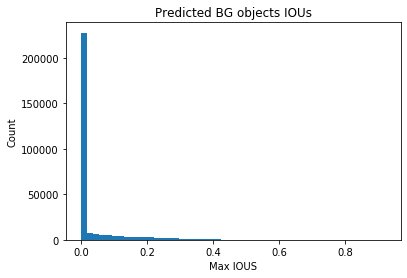

FPs: 3700
FNs: 54765
TPs: 9415
TNs: 237786

Total FG detections: 13115
Total BG detections: 292551

FP/TP+FP: 28.211971%
FN/TN+FN: 18.719813%


In [13]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train.hdf5")
show_max_ious_dist(save_path)

#### Kitti Val

In [14]:
%reset -f array

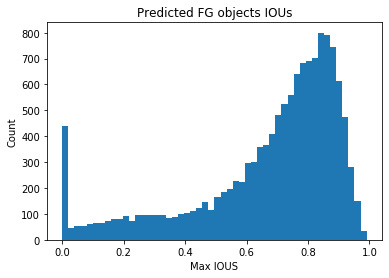

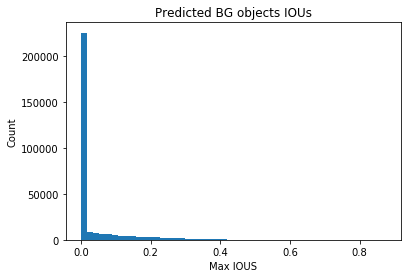

FPs: 5460
FNs: 64129
TPs: 7964
TNs: 233229

Total FG detections: 13424
Total BG detections: 297358

FP/TP+FP: 40.673421%
FN/TN+FN: 21.566260%


In [15]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val.hdf5")
show_max_ious_dist(save_path)

#### IDD Val

In [16]:
%reset -f array

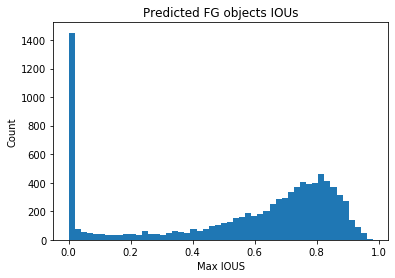

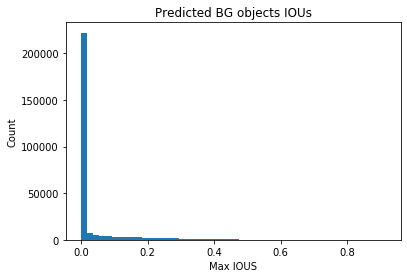

FPs: 4766
FNs: 74270
TPs: 4112
TNs: 204153

Total FG detections: 8878
Total BG detections: 278423

FP/TP+FP: 53.683262%
FN/TN+FN: 26.675239%


In [17]:
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val.hdf5")
show_max_ious_dist(save_path)

# Max Softmax

#### Kitti val

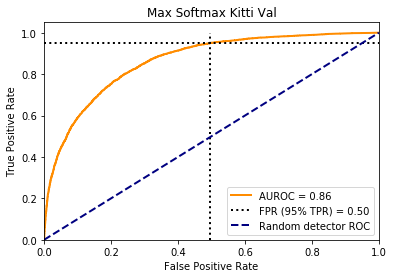

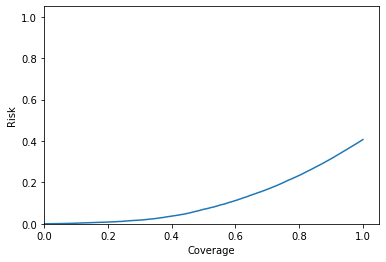

{'fpr_at_95_tpr': 0.496735308890005, 'detection_error': 0.2729281767955801, 'auroc': 0.8628160743492235, 'aupr_in': 0.8072416360709921, 'aupr_out': 0.8982402214760286}


In [18]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val.hdf5")
kitti_val_X, kitti_val_y = read_scores(save_path)

kitti_val_novelty_scores = -kitti_val_X
plot_roc(kitti_val_novelty_scores, kitti_val_y, title="Max Softmax Kitti Val")
cr_kitti_softmax = risk_coverage(kitti_val_novelty_scores, kitti_val_y)

#### IDD val

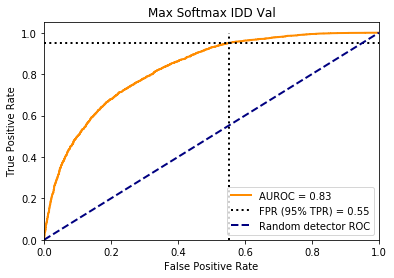

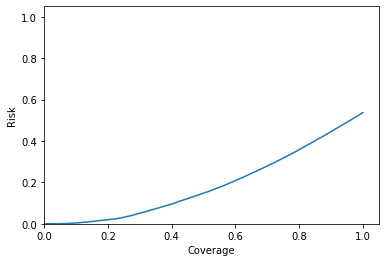

{'fpr_at_95_tpr': 0.5520428015564203, 'detection_error': 0.3009899278449328, 'auroc': 0.8274432905502824, 'aupr_in': 0.8312472708391049, 'aupr_out': 0.8198573114054868}


In [19]:
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val.hdf5")
idd_val_X, idd_val_y = read_scores(save_path)

idd_val_novelty_scores = -idd_val_X
plot_roc(idd_val_novelty_scores, idd_val_y, title="Max Softmax IDD Val")
cr_idd_softmax = risk_coverage(idd_val_novelty_scores, idd_val_y)

## One-Class SVM on Kitti features (Conv-512 layer)

#### Kitti Val

In [22]:
%reset -f array

In [23]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val.hdf5")

kitti_val_novelty_scores, kitti_val_y = chunked_calc(
    read_features, [save_path, 0], save_path, clf.decision_function, 1000)

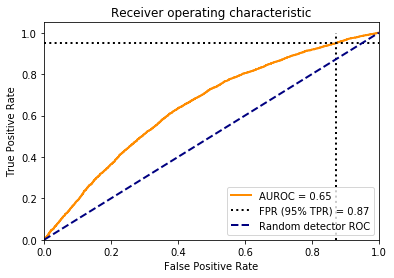

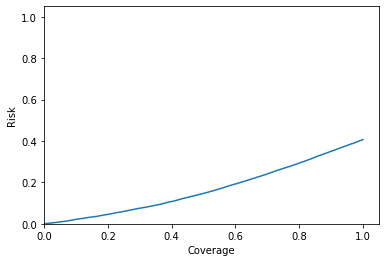

{'fpr_at_95_tpr': 0.8724259166248116, 'detection_error': 0.46112138322083074, 'auroc': 0.6496703112725212, 'aupr_in': 0.5268093698362369, 'aupr_out': 0.718427400844514}


In [24]:
plot_roc(-kitti_val_novelty_scores, kitti_val_y)
cr_kitti_svm_conv = risk_coverage(-kitti_val_novelty_scores, kitti_val_y)

#### IDD Val

In [25]:
%reset -f array

In [26]:
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val.hdf5")

idd_val_novelty_scores, idd_val_y = chunked_calc(
    read_features, [save_path, 0], save_path, clf.decision_function, 1000)

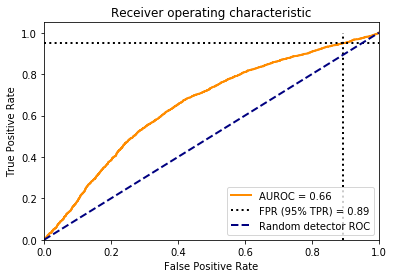

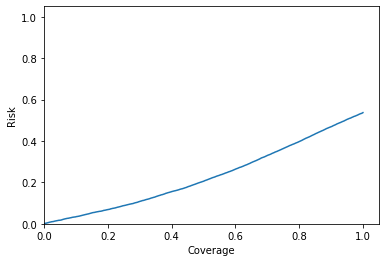

{'fpr_at_95_tpr': 0.893239299610895, 'detection_error': 0.47158817687217014, 'auroc': 0.6553339019007856, 'aupr_in': 0.6548809113195563, 'aupr_out': 0.5921179566673376}


In [27]:
plot_roc(-idd_val_novelty_scores, idd_val_y)
cr_idd_svm_conv = risk_coverage(-idd_val_novelty_scores, idd_val_y)

## One-Class SVM on Kitti features (FC-4096 (#1) layer) 

In [29]:
# Train a one-class SVM networks with those features
ONE_CLASS_SAVE_PATH = os.path.join(CHECKPOINT_DIR, "kitti-fc-4096-1-one-class.pickle")
with open(ONE_CLASS_SAVE_PATH, 'rb') as f:
    clf = pickle.load(f)

#### Kitti Val

In [30]:
%reset -f array

In [31]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val.hdf5")

kitti_val_novelty_scores, kitti_val_y = chunked_calc(
    read_features, [save_path, 1], save_path, clf.decision_function, 1000)

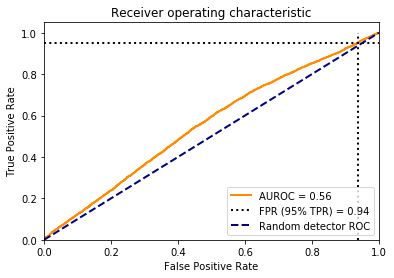

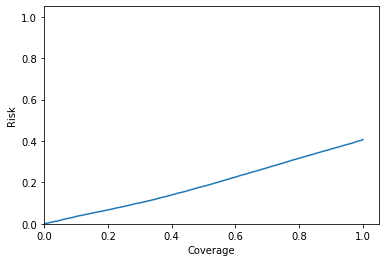

{'fpr_at_95_tpr': 0.9363385233550979, 'detection_error': 0.49230746233508665, 'auroc': 0.5557225923248023, 'aupr_in': 0.44877764961745154, 'aupr_out': 0.6363608242040046}


In [32]:
plot_roc(-kitti_val_novelty_scores, kitti_val_y)
cr_kitti_svm_fc = risk_coverage(-kitti_val_novelty_scores, kitti_val_y)

#### IDD Val

In [33]:
%reset -f array

In [34]:
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val.hdf5")

idd_val_novelty_scores, idd_val_y = chunked_calc(
    read_features, [save_path, 1], save_path, clf.decision_function, 1000)

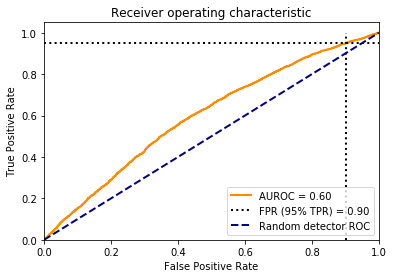

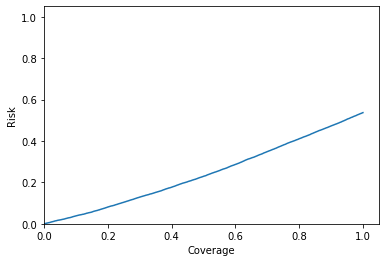

{'fpr_at_95_tpr': 0.9017509727626459, 'detection_error': 0.4758440134480456, 'auroc': 0.5992466651345213, 'aupr_in': 0.6090305268597482, 'aupr_out': 0.5515418258009016}


In [35]:
plot_roc(-idd_val_novelty_scores, idd_val_y)
cr_idd_svm_fc = risk_coverage(-idd_val_novelty_scores, idd_val_y)

# Mahalanobis

In [36]:
%reset -f array

In [37]:
mahal_model_name = os.path.join(CHECKPOINT_DIR, "kitti-cars-fc-4096-4-mahalanobis.h5")
md = Mahal_Dist.load(mahal_model_name)

#### Kitti val

In [38]:
%reset -f array

In [39]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val.hdf5")

kitti_val_novelty_scores, kitti_val_y = chunked_calc(
    read_features, [save_path, 4], save_path, md, 1000)

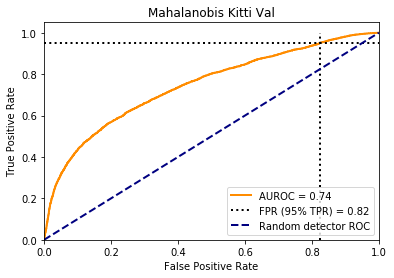

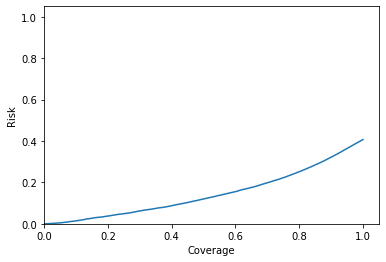

{'fpr_at_95_tpr': 0.8230788548468106, 'detection_error': 0.4364190597616012, 'auroc': 0.7443797914792389, 'aupr_in': 0.6849191659761833, 'aupr_out': 0.7831330693684839}


In [40]:
plot_roc(kitti_val_novelty_scores, kitti_val_y, title="Mahalanobis Kitti Val")
cr_kitti_mahal = risk_coverage(kitti_val_novelty_scores, kitti_val_y)

#### IDD val

In [41]:
%reset -f array

In [42]:
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val.hdf5")

idd_val_novelty_scores, idd_val_y = chunked_calc(
    read_features, [save_path, 4], save_path, md, 1000)

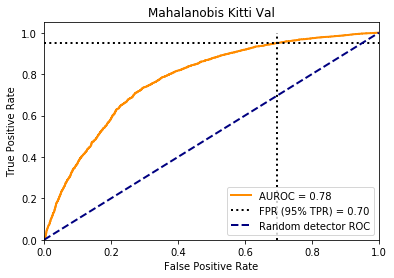

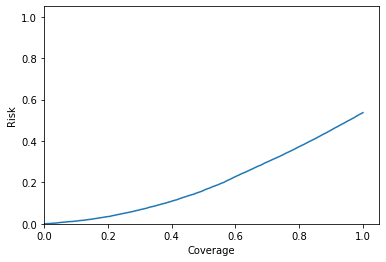

{'fpr_at_95_tpr': 0.6967412451361867, 'detection_error': 0.37325092541037275, 'auroc': 0.7759410090687767, 'aupr_in': 0.7701085554237969, 'aupr_out': 0.7489077168130549}


In [43]:
plot_roc(idd_val_novelty_scores, idd_val_y, title="Mahalanobis Kitti Val")
cr_idd_mahal = risk_coverage(idd_val_novelty_scores, idd_val_y)

## ODIN

### Find best params

In [44]:
# for T 1, 2, 5, 10,20, 50, 100, 200, 500, 1000; and for perturbation magnitude
# ε we choose from 21 evenly spaced numbers starting from 0
# and ending at 0.004.

# temperatures = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000])
temperatures = np.array([1000])
epsilons = np.linspace(0, 0.004, 21)
odin_params = list(itertools.product(epsilons, temperatures))

In [45]:
results = []

trainer.faster_rcnn.eval()
for eps, temp in tqdm(odin_params, total=len(odin_params)):
    save_file = os.path.join(CHECKPOINT_DIR, "subset_kitti_cars_detections_val_pert_%f_temp_%d.hdf5" % (eps, temp))
    
    print("ODIN Kitti Val e=%f, T=%d" % (eps, temp))
    kitti_val_X, kitti_val_y = read_scores(save_file, leave=False)
    kitti_val_novelty_scores = -kitti_val_X
    results.append(calc_metrics(kitti_val_novelty_scores, kitti_val_y))

/opt/conda/conda-bld/pytorch_1565272271120/work/torch/csrc/autograd/python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)



ODIN Kitti Val e=0.000000, T=1000


/opt/conda/conda-bld/pytorch_1565272271120/work/torch/csrc/autograd/python_function.cpp:664: UserWarning: Legacy autograd function object was called twice.  You will probably get incorrect gradients from this computation, as the saved tensors from the second invocation will clobber the saved tensors from the first invocation.  Please consider rewriting your autograd function in the modern style; for information on the new format, please see: https://pytorch.org/docs/stable/notes/extending.html#extending-torch-autograd



ODIN Kitti Val e=0.000200, T=1000



ODIN Kitti Val e=0.000400, T=1000



ODIN Kitti Val e=0.000600, T=1000


--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/l

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/e

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res 

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "<ipython-input-10-3d106a0e9bfd>", line 57, in extract_kitti_features
    _extract_features("kitti", dataset, model, save_file, perturbation, temperature)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkerne

  File "<ipython-input-10-3d106a0e9bfd>", line 57, in extract_kitti_features
    _extract_features("kitti", dataset, model, save_file, perturbation, temperature)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "<ipython-input-10-3d106a0e9bfd>", line 9, in _extract_features
    for i, res in tqdm(enumerate(dataloader), total=len(dataloader)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.p

  File "<ipython-input-10-3d106a0e9bfd>", line 57, in extract_kitti_features
    _extract_features("kitti", dataset, model, save_file, perturbation, temperature)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 2781, in open
    preinit()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 393, in preinit
    from . import JpegImagePlugin
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/GifImagePlugin.py", line 50, in <module>
    class GifImageFile(ImageFile.ImageFile):
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.py", line 138, in __getitem__
    ori_img, bbox, label, difficult = self.db.get_example(idx)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 256, in __getitem__
    return self.dataset[self.indices[idx]]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  Fil

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/GifImagePlugin.py", line 27, in <module>
    from . import Image, ImageFile, ImagePalette, ImageChops, ImageSequence
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "<frozen importlib._bootstrap_external>", line 724, 

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "/home/t

  File "<frozen importlib._bootstrap_external>", line 857, in get_code
  File "<frozen importlib._bootstrap_external>", line 525, in _compile_bytecode
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/ImageChops.py", line 210, in <module>
    def logical_and(image1, image2):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "/ho

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "/home/


ODIN Kitti Val e=0.000800, T=1000



ODIN Kitti Val e=0.001000, T=1000



ODIN Kitti Val e=0.001200, T=1000



ODIN Kitti Val e=0.001400, T=1000


--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
--- Logging error ---
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/l

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
--- Logging error ---
BrokenPipeError: [Errno 32] Broken pipe
--- Logging error ---
BrokenPipeError: [Errno 32] Broken pipe
BrokenPipeError: [Errno 32] Broken pipe
Call stack:
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
Call stack:
--- Logging error ---
Call stack:
Traceback (most recent call last):
Traceback (most recent call last):
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Call stack:
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaco

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._cont

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 714, in __init__
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
    yie

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=sile

  File "<ipython-input-10-3d106a0e9bfd>", line 9, in _extract_features
    for i, res in tqdm(enumerate(dataloader), total=len(dataloader)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "<ipython-input-10-3d106a0e9bfd>", line 57, in extract_kitti_features
    _extract_features("kitti", dataset, model, save_file, perturbation, temperature)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "<ipython-input-10-3d106a0e9bfd>", line 9, in _extract_features
    for i, res in tqdm(enumerate(dataloader), total=len(dataloader)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core

  File "<ipython-input-10-3d106a0e9bfd>", line 9, in _extract_features
    for i, res in tqdm(enumerate(dataloader), total=len(dataloader)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "<ipython-input-45-d12e08dde4ae>", line 8, in <module>
    extract_kitti_features(subset_kitti_val_dataset, trainer.faster_rcnn, save_file, eps, temp)
  File "<ipython-input-10-3d106a0e9bfd>", line 57, in extract_kitti_features
    _extract_features("kitti", dataset, model, save_file, perturbation, temperature)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 2781, in open
    preinit()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 256, in __getitem__
    return self.dataset[self.indices[idx]]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 2781, in open
    preinit()
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.py", line 138, in __getitem__
    ori_img, bbox, label, difficult = self.db.get_example(idx)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 393, in preinit
    from . import JpegImagePlugin
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _defa

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/JpegImagePlugin.py", line 41, in <module>
    from . import Image, ImageFile, TiffImagePlugin
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 256, in __getitem__
    return self.dataset[self.indices[idx]]
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "<frozen importlib._bootstrap>", line 1035, in

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "<frozen importlib._bootstrap_external>", line 857, in get_code
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.py", line 138, in __getitem__
    ori_img, bbox, label, difficult = self.db.get_example(idx)
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  

  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "<frozen importlib._bootstrap>", line 980, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "<frozen importlib._bootstrap>", line 148, in __enter__
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
Message: 'WARNING: attempted to send message from fork\n%s'
Arguments: {'header': {'msg_id': '11c75d80-0caf86d0c1c8801d27b2edd3', 'msg_type': 'comm_msg', 'username': 'tadenoud', 'session': 'd5dbd016-f81e355326ba70e4fcfa5890', 'date': datetime.datetime(2020, 1, 7, 4, 34, 25, 377306, tzinfo=datetime.timezone.utc), 'version': '5.3'}, 'msg_id': '11c75d80-0caf86d0c1c8801d27b2edd3', 'msg_type': 'comm_msg', 'parent_header': {'msg_id': '6e4027227a2648008b64418efc681e6b', 'username': 'username', 'session': '384e171780b44623a69826401bde9583', 'msg_type': 'execute_request', 'version': '5.2', 'date': datetime.datetime(2020, 1, 7, 4, 17, 9, 551878, tzinfo=datetime.timezone.utc)}, 'content': {'data': {'method': 'update', 'state': {'value': '


ODIN Kitti Val e=0.001600, T=1000



ODIN Kitti Val e=0.001800, T=1000



ODIN Kitti Val e=0.002000, T=1000



ODIN Kitti Val e=0.002200, T=1000


--- Logging error ---
--- Logging error ---
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
--- Logging error ---
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
--- Logging error ---
--- Logging error ---
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
Call stack:
--- Logging error ---
Traceback (most recent call last):
--- Logging error ---
Traceback (most recent call last):
--- Logging error ---
BrokenPipeError:

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_glo

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 714, in __init__
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 714, in __init__
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyn

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 714, in __init__
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py"

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/si

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-3d106a0e9bfd>", line 57, in extract_kitti_features
    _extract_features("kitti", dataset, model, save_file, perturbation, temperature)
  File "<ipython-input-10-3d106a0e9bfd>", line 9, in _extract_features
    for i, res in tqdm(enumerate(dataloader), total=len(dataloader)):
  File "<ipython-input-10-3d106a0e9bfd>", line 9, in _extract_features
    for i, res in tqdm(enumerate(dataloader), total=len(dataloader)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/pyt

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_o

  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 393, in preinit
    from . import JpegImagePlugin
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py",

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "<ipython-input-45-d12e08dde4ae>", line 8, in <module>
    extract_kitti_features(subset_kitti_val_dataset, trainer.faster_rcnn, save_file, eps, temp)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 2781, in open
    preinit()
  File "/home/tadenoud/anaconda3/envs/nn/lib/pyth

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 393, in preinit
    from . import JpegImagePlugin
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "/home/ta

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/tadenoud/anaconda3/envs

  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 2781, in open
    preinit()
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 393, in preinit
    from . import JpegImagePlugin
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
M

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
Message: 'WARNING: attempted to send message from fork\n%s'
Arguments: {'header': {'msg_id': 'e003ee9e-609fb083389543aa4b04c056', 'msg_type': 'comm_msg', 'username': 'tadenoud', 'session': 'd5dbd016-f81e355326ba70e4fcfa5890', 'date': datetime.datetime(2020, 1, 7, 4, 43, 32, 931039, tzinfo=datetime.timezone.utc), 'version': '5.3'}, 'msg_id': 'e003ee9e-609fb083389543aa4b04c056', 'msg_type': 'comm_msg', 'parent_header': {'msg_id':


ODIN Kitti Val e=0.002400, T=1000



ODIN Kitti Val e=0.002600, T=1000



ODIN Kitti Val e=0.002800, T=1000



ODIN Kitti Val e=0.003000, T=1000


--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---


--- Logging error ---
--- Logging error ---
--- Logging error ---
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Bro

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/pyth

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, i

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/env

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "<ipython-input-10-3d106a0e9bfd>", line 9, in _extract_features
    for i, res in tqdm(enumerate(dataloader), total=len(dataloader)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded 

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 256, in __getitem__
    return self.dataset[self.indices[idx]]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 256, in __getitem__
    return self.dataset[self.indices[idx]]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", li

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.py", line 138, in __getitem__
    ori_img, bbox, label, difficult = self.db.get_example(idx)
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap_external>", line 724, in exec_m

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 405, in preinit
    from . import PngImagePlugin
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.py", line 138, in __getitem__
    ori_img, bbox, label, difficult = self.db.get_example(idx)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "/home/t

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.py", line 138, in __getitem__
    ori_img, bbox, label, difficult = self.db.get_example(idx)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    p

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "<ipython-input-10-3d106a0e9bfd>", line 57, in extract_kitti_features
    _extract_features("kitti", dataset, model, save_file, perturbation, temperature)
  File "<frozen importlib._bootstrap_external>", line 525, in _compile_bytecode
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/tra

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitle

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
Message: 'WARNING: attempted to send message from fork\n%s'
Arguments: {'header': {'msg_id': '0a3c1128-74c801a7b4fedcd5fcc0548e', 'msg_type': 'comm_msg', 'username': 'tadenoud', 'session': 'd5dbd016-f81e355326ba70e4fcfa5890', 'date': datetime.datet


ODIN Kitti Val e=0.003200, T=1000



ODIN Kitti Val e=0.003400, T=1000



ODIN Kitti Val e=0.003600, T=1000



ODIN Kitti Val e=0.003800, T=1000


--- Logging error ---
--- Logging error ---
--- Logging error ---
Traceback (most recent call last):
--- Logging error ---
Traceback (most recent call last):


Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
--- Logging error ---
--- Logging error ---
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [E

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 714, in __init__
    self.run()
  File "/home/taden

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "<ipython-input-45-d12e08dde4ae>", line 8, in <module>
    extract_kitti_features(subset_kitti_val_dataset, trainer.faster_rcnn, save_file, eps, temp)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "<ipython-input-10-3d106a0e9bfd>", line 57, in extract_kitti_features
    _extract_features("kitti", dataset, model, save_file, perturbation, temperature)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkern

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.p

  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 256, in __getitem__
    return self.dataset[self.indices[idx]]
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/tadenoud/anaconda3/

  File "<frozen importlib._bootstrap_external>", line 857, in get_code
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 2781, in open
    preinit()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 405, in preinit
    from . import PngImagePlugin
  File "<frozen importlib._bootstrap_external>", line 525, in _compile_bytecode
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 677, in _load_u

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tadenoud/anaconda3/envs/nn/lib/pyth

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj.

  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/PngImagePlugin.py", line 105, in <module>
    class ChunkStream(object):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 2781, in open
    preinit()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-p

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
Message: 'WARNING: attempted to send message from fork\n%s'
Arguments: {'header': {'msg_id': '46e9125d-b163e193779910bfe1672987', 'msg_type': 'comm_msg', 'username': 'tadenoud', 'session': 'd5dbd016-f81e355326ba70e4fcfa5890', 'date': datetime.datetime(2020, 1, 7, 5, 1, 43, 375670, tzinfo=datetime.timezone.utc), 'version': '5.3'}, 'msg_id': '46e9125d-b163e193779910bfe1672987', 'msg_type': 'comm_msg', 'parent_header': {'msg_id': '6e4027227a2648008b64418efc681e6b', 'username': 'username', 'session': '384e171780b44623a69826401bde9583', 'msg_type': 'execute_request', 'vers


ODIN Kitti Val e=0.004000, T=1000


In [46]:
best_params = np.argmin([x['fpr_at_95_tpr'] for x in results[1:]])
print("Best params:", odin_params[1:][best_params])

eps, temp = odin_params[1:][best_params]

Best params: (0.0026000000000000003, 1000)


### Calc results for data using found params

#### Kitti val

In [47]:
%reset -f array

In [48]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_pert_%f_temp_%d.hdf5" % (eps, temp))

print("ODIN Kitti Val e=%f, T=%d" % (eps, temp))

kitti_val_novelty_scores, kitti_val_y = chunked_calc(
    read_scores, [save_path], save_path, lambda x: -x, 1000)


ODIN Kitti Val e=0.002600, T=1000


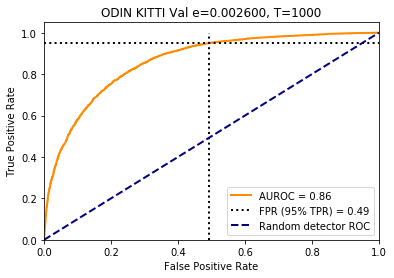

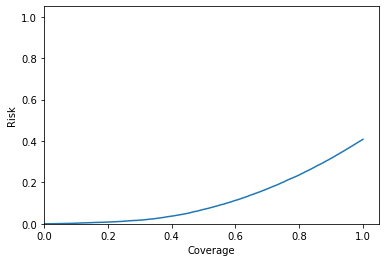

{'fpr_at_95_tpr': 0.49401687870008815, 'detection_error': 0.2718622405196347, 'auroc': 0.8621333427619516, 'aupr_in': 0.8039470031334631, 'aupr_out': 0.8979777919684246}


In [49]:
plot_roc(kitti_val_novelty_scores, kitti_val_y, title="ODIN KITTI Val e=%f, T=%d" %(eps, temp))
cr_kitti_odin = risk_coverage(kitti_val_novelty_scores, kitti_val_y)

#### IDD val

In [50]:
%reset -f array

In [51]:
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val_pert_%f_temp_%d.hdf5" % (eps, temp))

idd_val_novelty_scores, idd_val_y = chunked_calc(
    read_scores, [save_path], save_path, lambda x: -x, 1000)

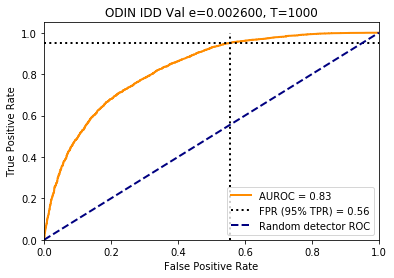

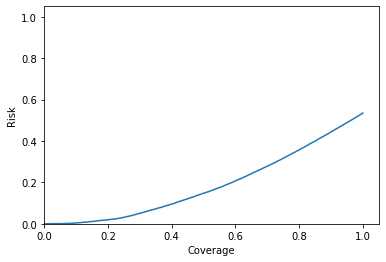

{'fpr_at_95_tpr': 0.5566658542529856, 'detection_error': 0.30324810948442327, 'auroc': 0.8263185908157564, 'aupr_in': 0.8277603927536975, 'aupr_out': 0.8197685938321274}


In [52]:
plot_roc(idd_val_novelty_scores, idd_val_y, title="ODIN IDD Val e=%f, T=%d" %(eps, temp))
cr_idd_odin = risk_coverage(idd_val_novelty_scores, idd_val_y)

## Entropy

In [54]:
import mc_uncertainty as mcu

NUM_MC_PASSES = 10

def read_mc_scores(save_file, start=0, end=None, leave=True):
    """
    Read the max_softmax scores from the extracted HD5F feature file and return them as a numpy array
    along with a label array y describing if the features correspond to a high IOU gt box with
    the same classification as the prediction.
    
    Label array is 1 for a true negative and 0 for a false negative
    """
    with h5py.File(save_file, "r") as f:       
        X = None
        y = np.empty((0,))
        
        if end is None or end > len(f):
            end = len(f)
        
        for i in trange(start, end, leave=leave):
            d = f[str(i)]
            features = d["mc_scores"][()]
            
            # Select only the negative preds
            label_is_fg = d["pred_labels"][()] >= 0
            mask = label_is_fg
            
            if X is None:
                # Initialize X array to correct size
                X = np.copy(features[:,mask])
            else:
                X = np.concatenate((X, features[:,mask]), axis=1)
            
            iou_is_high_enough = d["pred_max_ious"][()][mask] >= MIN_IOU_REQUIRED
            classification_is_correct = d["pred_label_correct"][()][mask] == 1

            # Determine if each bbox is a high accuracy, correct class case
            label = iou_is_high_enough & classification_is_correct
            y = np.concatenate((y, label.astype(np.int)), axis=0)
            
    return X, 1 - y

#### Kitti Val

In [55]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_mc_dropout.hdf5")

kitti_val_novelty_scores, kitti_val_y = chunked_calc(
    read_mc_scores, [save_path], save_path, mcu.predicted_entropy, 1000)

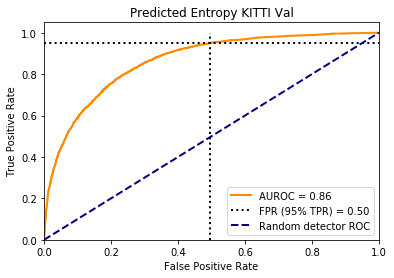

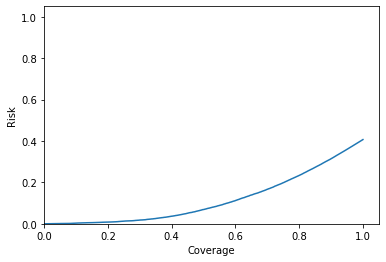

{'fpr_at_95_tpr': 0.49522852837769965, 'detection_error': 0.27243111400569964, 'auroc': 0.8631387604108598, 'aupr_in': 0.8070715320207802, 'aupr_out': 0.8983792772223457}


In [56]:
plot_roc(kitti_val_novelty_scores, kitti_val_y, title="Predicted Entropy KITTI Val")
cr_kitti_entropy = risk_coverage(kitti_val_novelty_scores, kitti_val_y)

#### IDD Val

In [57]:
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val_mc_dropout.hdf5")

idd_val_novelty_scores, idd_val_y = chunked_calc(
    read_mc_scores, [save_path], save_path, mcu.predicted_entropy, 1000)

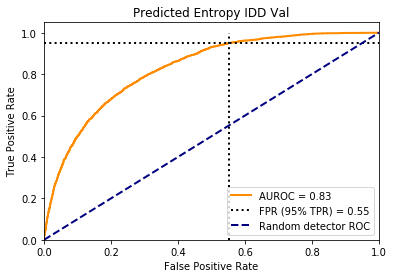

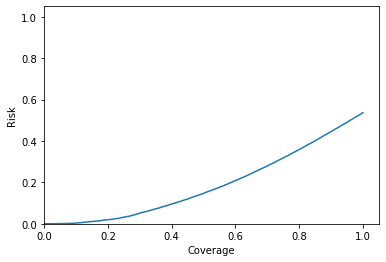

{'fpr_at_95_tpr': 0.5522859922178989, 'detection_error': 0.3011115231756721, 'auroc': 0.8280867814088444, 'aupr_in': 0.8309429132634149, 'aupr_out': 0.8207754004900651}


In [58]:
plot_roc(idd_val_novelty_scores, idd_val_y, title="Predicted Entropy IDD Val")
cr_idd_entropy = risk_coverage(idd_val_novelty_scores, idd_val_y)

## Mutual Information

#### Kitti Val

In [59]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_mc_dropout.hdf5")

kitti_val_novelty_scores, kitti_val_y = chunked_calc(
    read_mc_scores, [save_path], save_path, mcu.mutual_information, 1000)

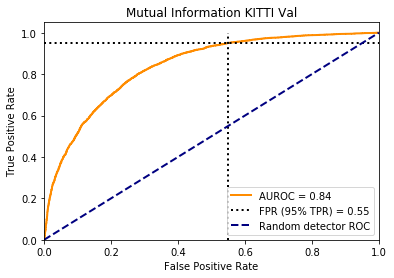

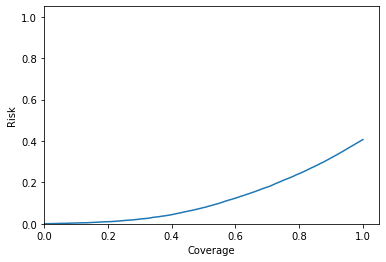

{'fpr_at_95_tpr': 0.5494726268206931, 'detection_error': 0.2994851833249624, 'auroc': 0.8380456215055663, 'aupr_in': 0.7642715814395074, 'aupr_out': 0.8798493910094441}


In [60]:
plot_roc(kitti_val_novelty_scores, kitti_val_y, title="Mutual Information KITTI Val")
cr_kitti_mi = risk_coverage(kitti_val_novelty_scores, kitti_val_y)

#### IDD Val

In [61]:
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val_mc_dropout.hdf5")

idd_val_novelty_scores, idd_val_y = chunked_calc(
    read_mc_scores, [save_path], save_path, mcu.mutual_information, 1000)

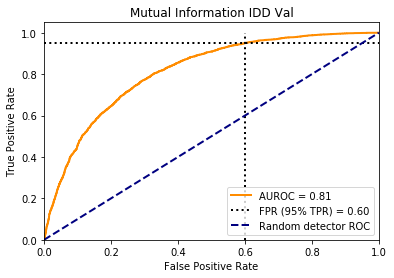

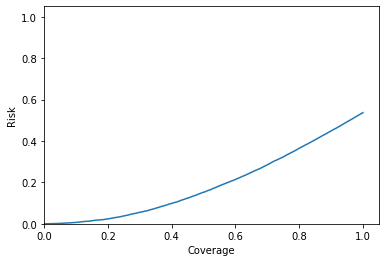

{'fpr_at_95_tpr': 0.60068093385214, 'detection_error': 0.32530899399279267, 'auroc': 0.8114697053627267, 'aupr_in': 0.8083166730314985, 'aupr_out': 0.7989595109480669}


In [62]:
plot_roc(idd_val_novelty_scores, idd_val_y, title="Mutual Information IDD Val")
cr_idd_mi = risk_coverage(idd_val_novelty_scores, idd_val_y)

# Vahdats Extended Feature Extractor Set

In [ ]:
# Train a one-class SVM networks with those features
GT_FEATURES_FILE = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train_extended_gt.hdf5")
SUBSET_KITTI_VAL_FEATURES_FILE = os.path.join(CHECKPOINT_DIR, "subset_kitti_cars_detections_val_extended.hdf5")
KITTI_TRAIN_FEATURES_FILE = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train_extended.hdf5")
KITTI_VAL_FEATURES_FILE = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_extended.hdf5")
IDD_VAL_FEATURES_FILE = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val_extended.hdf5")
NUM_EXTENDED_FEATURES = 30

In [ ]:
def read_extended_features(file, feature_idx):
    X = None
    y = np.empty((0,))

    with h5py.File(file, "r") as f:
        for im in tqdm(f.keys(), total=len(f), leave=False):
            im = f[im]            
            
            # Select only the negative preds
            label_is_fg = im['pred']["pred_labels"][()] >= 0
            mask = label_is_fg
            
            iou_is_high_enough = im['pred']["pred_max_ious"][()][mask] >= MIN_IOU_REQUIRED
            classification_is_correct = im['pred']["pred_label_correct"][()][mask] == 1

            # Determine if each bbox is a high accuracy, correct class case
            label = iou_is_high_enough & classification_is_correct
            y = np.concatenate((y, label.astype(np.int)), axis=0)

            # Get the required features
            for j in np.array(sorted(im['bboxes'].keys())):#[mask]:
                bbox = im['bboxes'][j]
                feats = bbox["extended_feat_%d" % feature_idx]

                if X is None:
                    X = np.expand_dims(feats, axis=0)
                else:
                    X = np.concatenate((X, np.expand_dims(feats, axis=0)), axis=0)
    
    return X, 1 - y

In [ ]:
NUS = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3]
# GAMMAS = ['auto', 'scale']
GAMMAS = ['auto']
# KERNELS = ['rbf', 'linear']
KERNELS = ['rbf']

train_args = list(itertools.product(NUS, GAMMAS, KERNELS))

### Determine best params/OODL

In [ ]:
with open(os.path.join(CHECKPOINT_DIR, 'one_class_models/subset_kitti_val_results.pickle'), 'rb') as f:
    kitti_val_results = pickle.load(f)

In [ ]:
best_params = np.argmin([k['detection_error'] for k in kitti_val_results])

oodl, (nu, gamma, kernel) = list(itertools.product(list(range(NUM_EXTENDED_FEATURES)), train_args))[best_params]

# Load the best classifier
save_path = os.path.join(CHECKPOINT_DIR, "one_class_models/kitti-one-class-extended-feat%d-nu%.4f-gamma%s-kernel%s.pickle" % (oodl, nu, gamma, kernel))
with open(save_path, 'rb') as f:
    clf = pickle.load(f)

### Kitti Val

In [ ]:
kitti_val_X, kitti_val_y = read_extended_features(KITTI_VAL_FEATURES_FILE, oodl)

# Calculate performance metrics
kitti_val_novelty_scores = clf.decision_function(kitti_val_X)
res = calc_metrics(kitti_val_novelty_scores, kitti_val_y.astype(np.int))

plot_roc(kitti_val_novelty_scores, kitti_val_y, title="SVM Vahdat")
cr_kitti_svm_vahdat = risk_coverage(kitti_val_novelty_scores, kitti_val_y)

### IDD VAL

In [ ]:
idd_val_X, idd_val_y = read_extended_features(IDD_VAL_FEATURES_FILE, oodl)

# Calculate performance metrics
idd_val_novelty_scores = clf.decision_function(idd_val_X)
res = calc_metrics(idd_val_novelty_scores, idd_val_y.astype(np.int))

plot_roc(idd_val_novelty_scores, idd_val_y, title="SVM Vahdat")
cr_idd_svm_vahdat = risk_coverage(idd_val_novelty_scores, idd_val_y)

## Mahalanobis with input perturbation

In [12]:
%reset -f array

In [13]:
# for T 1, 2, 5, 10,20, 50, 100, 200, 500, 1000; and for perturbation magnitude
# ε we choose from 21 evenly spaced numbers starting from 0
# and ending at 0.004.

# temperatures = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000])
temperatures = np.array([1000])

epsilons = np.linspace(0, 0.004, 21)
# epsilons = np.array([0.0034])

odin_params = list(itertools.product(epsilons, temperatures))

In [15]:
%reset -f array

In [16]:
results2 = []
for eps, temp in tqdm(odin_params, total=len(odin_params)):
    # Get the data
    save_path = os.path.join(CHECKPOINT_DIR, "subset_kitti_cars_detections_val_pert_%f_temp_%d.hdf5" % (eps, temp))
    kitti_val_X, kitti_val_y = read_features(save_path, 4)
    
    # Load the model
    mahal_model_name = os.path.join(CHECKPOINT_DIR, "kitti-cars-fc-4096-4-mahalanobis_pert_%f_temp_%d.pickle" % (eps, temp))
    md = Mahal_Dist.load(mahal_model_name)
    
    kitti_val_novelty_scores = md(kitti_val_X)
    results2.append(calc_metrics(kitti_val_novelty_scores, kitti_val_y))

In [17]:
# Pick the best eps and temp

idx = np.argmin(x['fpr_at_95_tpr'] for x in results2[1:])
eps, temp = odin_params[1:][idx]
print("e:", eps, "T:", temp)

# Load the model
mahal_model_name = os.path.join(CHECKPOINT_DIR, "kitti-cars-fc-4096-4-mahalanobis_pert_%f_temp_%d.pickle" % (eps, temp))
md = Mahal_Dist.load(mahal_model_name)

e: 0.0002 T: 1000


#### Kitti val

In [18]:
%reset -f array

In [19]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val.hdf5")

kitti_val_novelty_scores, kitti_val_y = chunked_calc(
    read_features, [save_path, 4], save_path, md, 1000)

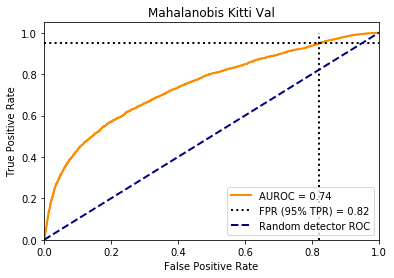

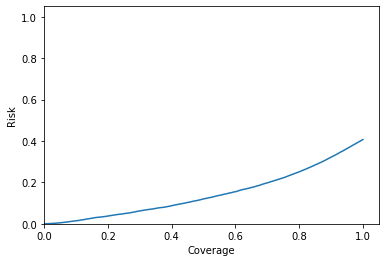

{'fpr_at_95_tpr': 0.82245102963335, 'detection_error': 0.43613393972509995, 'auroc': 0.7444958816505779, 'aupr_in': 0.6853259864657202, 'aupr_out': 0.7828474955846794}


In [20]:
plot_roc(kitti_val_novelty_scores, kitti_val_y, title="Mahalanobis Kitti Val")
cr_kitti_mahal_p = risk_coverage(kitti_val_novelty_scores, kitti_val_y)

#### IDD val

In [21]:
%reset -f array

In [22]:
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val.hdf5")

idd_val_novelty_scores, idd_val_y = chunked_calc(
    read_features, [save_path, 4], save_path, md, 1000)

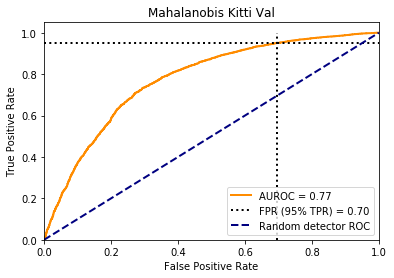

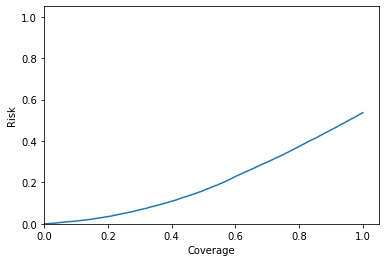

{'fpr_at_95_tpr': 0.6962548638132295, 'detection_error': 0.37288613941815485, 'auroc': 0.7748027175714489, 'aupr_in': 0.7666562944439106, 'aupr_out': 0.7486321774869293}


In [23]:
plot_roc(idd_val_novelty_scores, idd_val_y, title="Mahalanobis Kitti Val")
cr_idd_mahal_p = risk_coverage(idd_val_novelty_scores, idd_val_y)

In [ ]:
# cr_kitti_softmax
# cr_idd_softmax
# cr_kitti_svm_conv
# cr_idd_svm_conv
# cr_kitti_svm_fc
# cr_idd_svm_fc
# cr_kitti_mahal
# cr_idd_mahal
# cr_kitti_odin
# cr_idd_odin
# cr_kitti_entropy
# cr_idd_entropy
# cr_kitti_mi
# cr_idd_mi
# cr_kitti_svm_vahdat
# cr_idd_svm_vahdat
# cr_kitti_mahal_p
# cr_idd_mahal_p